In [1]:
################################################################################################################################
#
# LSTM - JANSEN - LN - DAILY
#
################################################################################################################################

#-------------------------------------------------------------------------------------------------------------------------------
# 'Train RMSE: 1250.34 | Test RMSE: 1510.92
#-------------------------------------------------------------------------------------------------------------------------------

#===============================================================================================================================
# ENVIRONMENT: LIBRARIES, SETTINGS
#===============================================================================================================================
#pip install pandas-datareader

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import sklearn
import sklearn.preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow import keras

In [2]:
#===============================================================================================================================
# ENVIRONMENT: HARDWARE
#===============================================================================================================================
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [3]:
#===============================================================================================================================
# ENVIRONMENT: CONFIG
#===============================================================================================================================
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
#===============================================================================================================================
# DATA: INPUT/OUTPUT
#===============================================================================================================================
input_path = Path('Data', 'Input')
results_path = Path('Data\Output', 'LSTM-Jansen-Ln-Daily')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [5]:
#===============================================================================================================================
# DATA: SETTINGS
#===============================================================================================================================
seriesId='IBOV'
#ESCALA = 'log'
#EPOCAS = 100
#LOTE = 50
#NEURONS = 32
window_size=21

#===============================================================================================================================
# DATA: READ
#===============================================================================================================================
df = pd.read_csv(seriesId+'.csv')
df.drop(['Open','Low','High', 'Qt'], axis='columns', inplace=True )
df['Date']= pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)
df

,Close
Date,
2000-01-03,16930.42
2000-01-04,15851.00
2000-01-05,16245.14
2000-01-06,16106.89
2000-01-07,16309.15
...,...
2023-12-21,132182.01
2023-12-22,132752.93
2023-12-26,133532.92


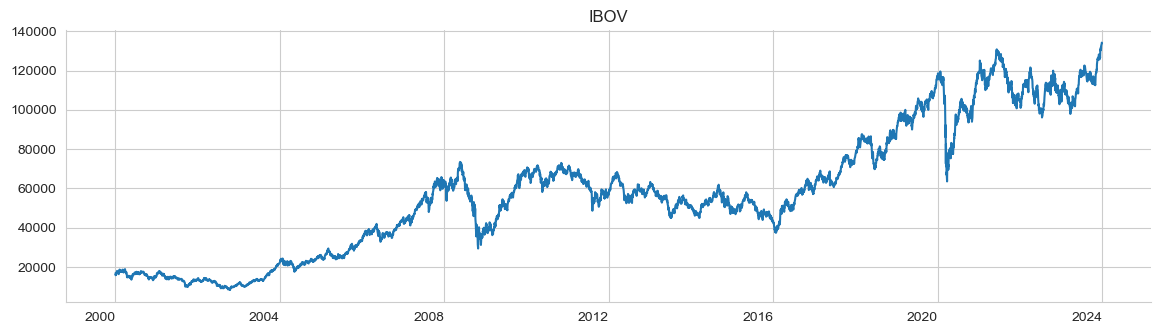

In [6]:
#===============================================================================================================================
# DATA: PLOT
#===============================================================================================================================
ax = df.plot(title=seriesId, legend=False, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [7]:
#===============================================================================================================================
# DATA: SCALE - LOG
#===============================================================================================================================
df_scaled = df.copy()
df_scaled['Close'] = np.log(df_scaled['Close'])

df_scaled.describe()

,Close
count,5943.000000
mean,10.767680
std,0.693749
min,9.032514
25%,10.410556
50%,10.928613
75%,11.219545
max,11.807040


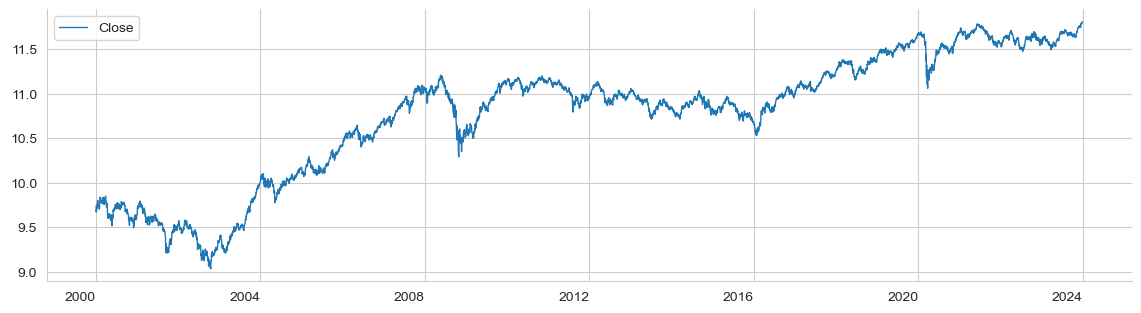

In [8]:
#===============================================================================================================================
# DATA: LOG - PLOT
#===============================================================================================================================
ax = df_scaled.plot(lw=1, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [9]:
#===============================================================================================================================
# DATA PREP: RECURRENT SEQUENCES - FUNCTION
#===============================================================================================================================
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    #y = data[window_size-1:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    #X = np.hstack(tuple([data[i: n-j+1, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [10]:
#===============================================================================================================================
# DATA PREP: RECURRENT SEQUENCES - RUN
#===============================================================================================================================
X, y = create_univariate_rnn_data(df_scaled, window_size=window_size)
X


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-02,9.736867,9.670988,9.695549,9.687002,9.699482,9.742270,9.715513,9.718174,9.758350,9.778941,...,9.792736,9.768254,9.751311,9.742979,9.739304,9.747141,9.745731,9.725221,9.704321,9.712460
2000-02-03,9.670988,9.695549,9.687002,9.699482,9.742270,9.715513,9.718174,9.758350,9.778941,9.801079,...,9.768254,9.751311,9.742979,9.739304,9.747141,9.745731,9.725221,9.704321,9.712460,9.733201
2000-02-04,9.695549,9.687002,9.699482,9.742270,9.715513,9.718174,9.758350,9.778941,9.801079,9.792736,...,9.751311,9.742979,9.739304,9.747141,9.745731,9.725221,9.704321,9.712460,9.733201,9.767503
2000-02-07,9.687002,9.699482,9.742270,9.715513,9.718174,9.758350,9.778941,9.801079,9.792736,9.768254,...,9.742979,9.739304,9.747141,9.745731,9.725221,9.704321,9.712460,9.733201,9.767503,9.794368
2000-02-08,9.699482,9.742270,9.715513,9.718174,9.758350,9.778941,9.801079,9.792736,9.768254,9.751311,...,9.739304,9.747141,9.745731,9.725221,9.704321,9.712460,9.733201,9.767503,9.794368,9.805081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,11.744317,11.748596,11.740199,11.741904,11.748300,11.745351,11.754546,11.761229,11.750388,11.751180,...,11.744113,11.752679,11.751284,11.747231,11.771166,11.781746,11.776805,11.783592,11.789427,11.781457
2023-12-22,11.748596,11.740199,11.741904,11.748300,11.745351,11.754546,11.761229,11.750388,11.751180,11.741038,...,11.752679,11.751284,11.747231,11.771166,11.781746,11.776805,11.783592,11.789427,11.781457,11.791935
2023-12-26,11.740199,11.741904,11.748300,11.745351,11.754546,11.761229,11.750388,11.751180,11.741038,11.744113,...,11.751284,11.747231,11.771166,11.781746,11.776805,11.783592,11.789427,11.781457,11.791935,11.796245


In [11]:
#===============================================================================================================================
# DATA PREP: SPLIT
#===============================================================================================================================
X_train = X[:'2022'].values.reshape(-1, window_size, 1)
y_train = y[:'2022']

# keep the last year for testing
X_test = X['2023':].values.reshape(-1, window_size, 1)
y_test = y['2023':]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5674, 21, 1), (5674, 1), (248, 21, 1), (248, 1))

In [12]:
#===============================================================================================================================
# DATA PREP: OBS, WINDOWS, FEATURES
#===============================================================================================================================
n_obs, window_size, n_features = X_train.shape
n_obs, window_size, n_features

(5674, 21, 1)

In [13]:
#===============================================================================================================================
# MODEL: LSTM
#===============================================================================================================================
rnn = Sequential([
    LSTM(units=10, input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

rnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
#===============================================================================================================================
# MODEL: CONFIG
#===============================================================================================================================
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, weight_decay=0.0)

rnn.compile(loss='mean_squared_error', optimizer=optimizer)

rnn_path = (results_path / 'Ln-Daily-rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path, verbose=1, monitor='val_loss', save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [15]:
#===============================================================================================================================
# MODEL: TRAIN
#===============================================================================================================================
lstm_training = rnn.fit(X_train, y_train, epochs=150, batch_size=20, shuffle=True, 
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stopping, checkpointer],verbose=1)

Epoch 1/150

282/284 [============================>.] - ETA: 0s - loss: 67.4456
Epoch 1: val_loss improved from inf to 46.69049, saving model to Data/Output/LSTM-Jansen-Ln-Daily\Ln-Daily-rnn.h5
284/284 [==============================] - 5s 9ms/step - loss: 67.2539 - val_loss: 46.6905
Epoch 2/150
283/284 [============================>.] - ETA: 0s - loss: 20.0844
Epoch 2: val_loss improved from 46.69049 to 13.65148, saving model to Data/Output/LSTM-Jansen-Ln-Daily\Ln-Daily-rnn.h5
284/284 [==============================] - 2s 7ms/step - loss: 20.0546 - val_loss: 13.6515
Epoch 3/150
277/284 [============================>.] - ETA: 0s - loss: 2.9919
Epoch 3: val_loss improved from 13.65148 to 0.93672, saving model to Data/Output/LSTM-Jansen-Ln-Daily\Ln-Daily-rnn.h5
284/284 [==============================] - 2s 7ms/step - loss: 2.9332 - val_loss: 0.9367
Epoch 4/150
282/284 [============================>.] - ETA: 0s - loss: 0.4665
Epoch 4: val_loss improved from 0.93672 to 0.90784, saving mode

Epoch 33/150
281/284 [============================>.] - ETA: 0s - loss: 0.0044
Epoch 33: val_loss did not improve from 0.00039
284/284 [==============================] - 2s 8ms/step - loss: 0.0044 - val_loss: 6.1180e-04
Epoch 34/150
277/284 [============================>.] - ETA: 0s - loss: 0.0045
Epoch 34: val_loss did not improve from 0.00039
284/284 [==============================] - 2s 8ms/step - loss: 0.0044 - val_loss: 0.0154
Epoch 35/150
284/284 [==============================] - ETA: 0s - loss: 0.0043
Epoch 35: val_loss did not improve from 0.00039
284/284 [==============================] - 2s 8ms/step - loss: 0.0043 - val_loss: 0.0010
Epoch 36/150
280/284 [============================>.] - ETA: 0s - loss: 0.0042
Epoch 36: val_loss did not improve from 0.00039
284/284 [==============================] - 3s 10ms/step - loss: 0.0042 - val_loss: 0.0123
Epoch 37/150
282/284 [============================>.] - ETA: 0s - loss: 0.0043
Epoch 37: val_loss did not improve from 0.00039
284/

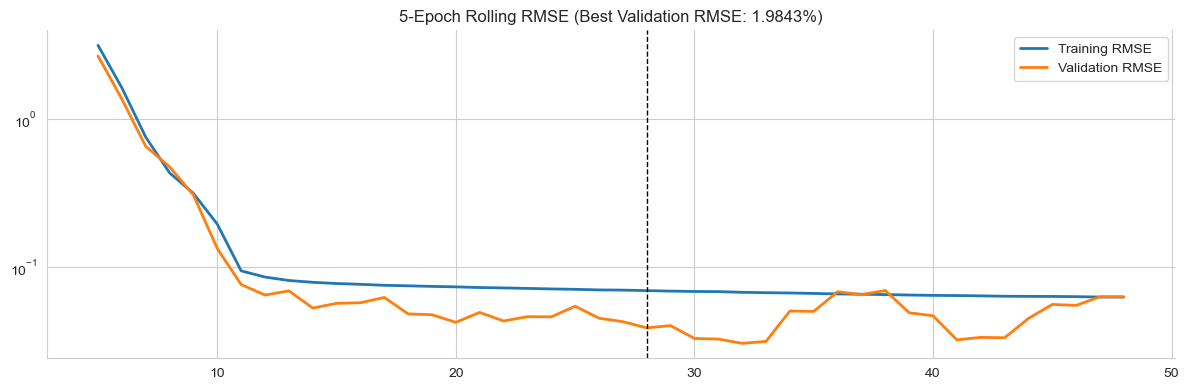

In [16]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

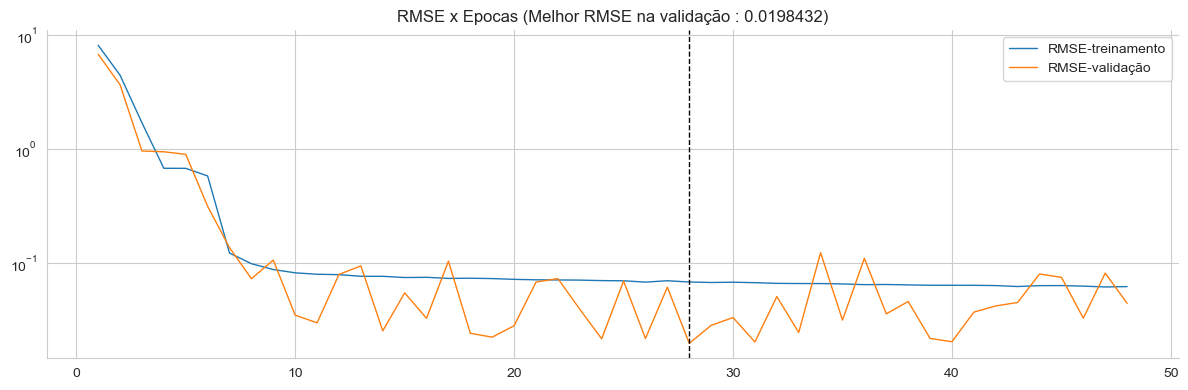

In [35]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'RMSE x Epocas (Melhor RMSE na validação : {best_rmse:.6})'
loss_history.columns=['RMSE-treinamento', 'RMSE-validação']
loss_history.rolling(1).mean().plot(logy=True, lw=1, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

In [17]:
#===============================================================================================================================
# RESULTS - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train RMSE: 0.0333 | Test RMSE: 0.0194
#-------------------------------------------------------------------------------------------------------------------------------

Train RMSE: 0.0318 | Test RMSE: 0.0198


In [18]:
#===============================================================================================================================
# RESULTS - FORECAST - TRAIN, TEST
#===============================================================================================================================
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

8/8 [==============================] - 0s 4ms/step


In [19]:
#===============================================================================================================================
# RESULTS - SPEARMAN IC - TRAIN, TEST
#===============================================================================================================================
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.6f} | Test IC: {test_ic:.4f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train IC: 0.998728 | Test IC: 0.9543
#-------------------------------------------------------------------------------------------------------------------------------

Train IC: 0.998454 | Test IC: 0.9530


In [20]:
#===============================================================================================================================
# RESULTS - FORECAST - SCALED - TEST 
#===============================================================================================================================
np.savetxt('Data/Output/LSTM-Jansen-Ln-Daily-Scaled-Train.txt', train_predict_scaled, delimiter=';')
np.savetxt('Data/Output/LSTM-Jansen-Ln-Daily-Scaled-Test.txt' , test_predict_scaled, delimiter =';')
test_predict_scaled[:,0]

array([11.605799 , 11.601086 , 11.59315  , 11.589566 , 11.5914345,
       11.595441 , 11.59884  , 11.60464  , 11.612231 , 11.616801 ,
       11.618596 , 11.616845 , 11.619716 , 11.623298 , 11.627234 ,
       11.628619 , 11.629153 , 11.631899 , 11.636231 , 11.639401 ,
       11.638592 , 11.63807  , 11.639908 , 11.638971 , 11.634774 ,
       11.628586 , 11.624246 , 11.619245 , 11.619396 , 11.615811 ,
       11.613233 , 11.612692 , 11.610354 , 11.611791 , 11.613426 ,
       11.613144 , 11.609012 , 11.606661 , 11.601301 , 11.597002 ,
       11.592153 , 11.587348 , 11.58151  , 11.578147 , 11.577298 ,
       11.575677 , 11.579063 , 11.578584 , 11.575215 , 11.571567 ,
       11.5683975, 11.565404 , 11.564628 , 11.560933 , 11.555803 ,
       11.552049 , 11.547521 , 11.5390625, 11.534645 , 11.533174 ,
       11.535315 , 11.538168 , 11.544289 , 11.544923 , 11.544494 ,
       11.544863 , 11.543191 , 11.541546 , 11.542537 , 11.552382 ,
       11.561072 , 11.566677 , 11.57054  , 11.5729685, 11.5752

In [21]:
#===============================================================================================================================
# RESULTS - PRICE - RECOVER - PRED - TRAIN, TEST
#===============================================================================================================================
train_predict = pd.Series(np.exp(train_predict_scaled[:,0]), index=y_train.index)
test_predict  = pd.Series(np.exp(test_predict_scaled[:,0]), index=y_test.index)

test_predict

Date
2023-01-02    109732.265625
2023-01-03    109216.304688
2023-01-04    108353.039062
2023-01-05    107965.414062
2023-01-06    108167.304688
                  ...      
2023-12-21    128486.289062
2023-12-22    128878.250000
2023-12-26    129281.531250
2023-12-27    129732.085938
2023-12-28    130195.390625
Length: 248, dtype: float32

In [22]:
#===============================================================================================================================
# RESULTS - PRICE - RECOVER - TARGET - TRAIN, TEST
#===============================================================================================================================
y_train_rescaled = np.exp(y_train['Close'])
y_test_rescaled  = np.exp(y_test['Close'])

y_test_rescaled

Date
2023-01-02    106376.02
2023-01-03    104165.74
2023-01-04    105334.46
2023-01-05    107641.32
2023-01-06    108963.70
                ...    
2023-12-21    132182.01
2023-12-22    132752.93
2023-12-26    133532.92
2023-12-27    134193.72
2023-12-28    134185.24
Name: Close, Length: 248, dtype: float64

In [23]:
#===============================================================================================================================
# RESULTS - PRICE - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
print(f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train RMSE: 1250.34 | Test RMSE: 1510.92
#-------------------------------------------------------------------------------------------------------------------------------

Train RMSE: 1853.03 | Test RMSE: 2252.92


In [24]:
#===============================================================================================================================
# RESULTS - PRICE - STORE - TRAIN, TEST
#===============================================================================================================================
df['Train Predictions'] = train_predict
df['Test Predictions'] = test_predict

temp = pd.concat([train_predict.to_frame('predictions').assign(data='Train'), test_predict.to_frame('predictions').assign(data='Test')])
df['predictions'] = temp['predictions']
df['data']        = temp[ 'data']

df['2022-12-29':]

,Close,Train Predictions,Test Predictions,predictions,data
Date,,,,,
2022-12-29,109734.60,109484.203125,NaN,109484.203125,Train
2023-01-02,106376.02,NaN,109732.265625,109732.265625,Test
2023-01-03,104165.74,NaN,109216.304688,109216.304688,Test
2023-01-04,105334.46,NaN,108353.039062,108353.039062,Test
2023-01-05,107641.32,NaN,107965.414062,107965.414062,Test
...,...,...,...,...,...
2023-12-21,132182.01,NaN,128486.289062,128486.289062,Test
2023-12-22,132752.93,NaN,128878.250000,128878.250000,Test
2023-12-26,133532.92,NaN,129281.531250,129281.531250,Test


In [25]:
#===============================================================================================================================
# RESULTS - PRICE - EXPORT
#===============================================================================================================================
df.to_excel('Data/Output/LSTM-Jansen-Ln-Daily.xlsx')

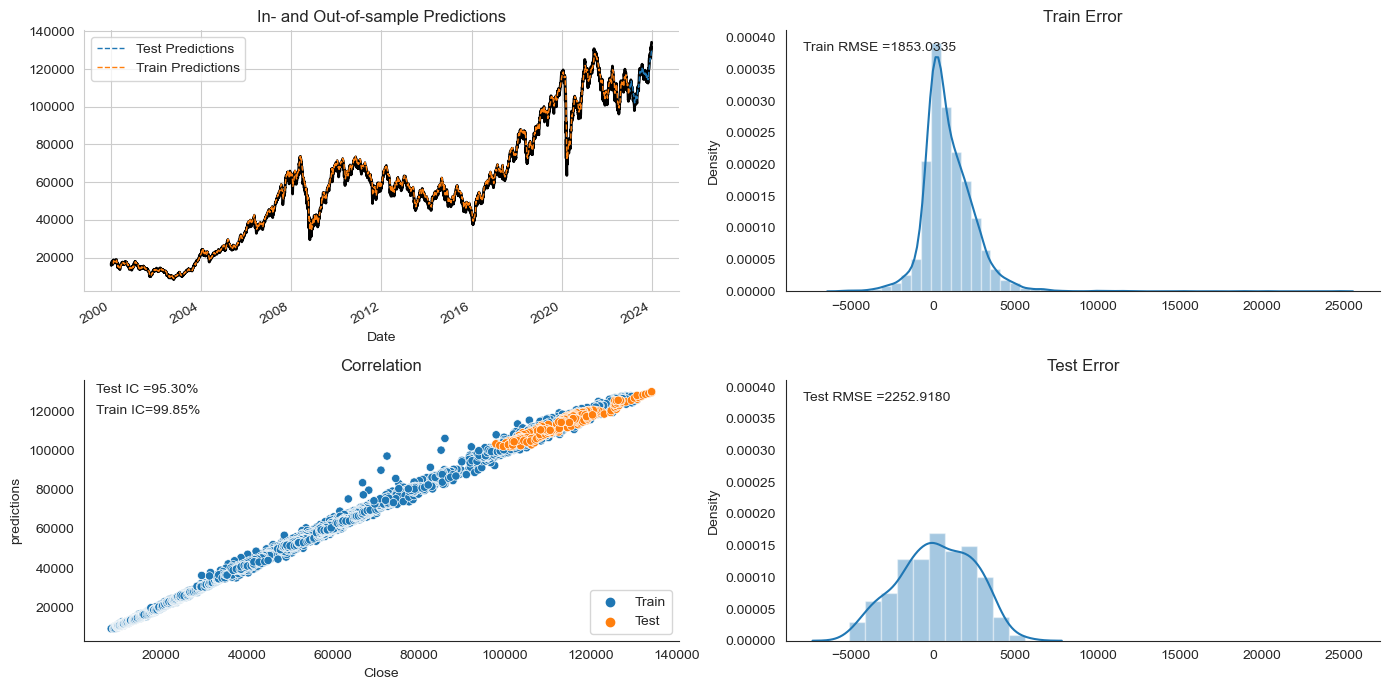

In [26]:
#===============================================================================================================================
# RESULTS - PRICE - PLOT
#===============================================================================================================================
fig=plt.figure(figsize=(14,7))

ax1 = plt.subplot(221)
df.loc['2000':, 'Close'].plot(lw=2, ax=ax1, c='k')
df.loc['2000':, 'predictions'].plot(lw=1.5, ax=ax1, c='k')
df.loc['2000':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')

with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='Close', y='predictions', data=df, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_regression', dpi=300);
